## Clustering

### Import libraries 

In [ ]:
# Import standard libraries
import os, datetime
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pl
import igraph
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bokeh
import hvplot.pandas
import holoviews as hv
from holoviews import opts
hv.extension('bokeh', 'matplotlib')
%matplotlib inline

import bokeh.palettes
from bokeh.plotting import figure, show, output_notebook
output_notebook()
import seaborn as sb
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz, load_npz
# import cairo
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import zscore
from scipy.sparse.linalg import norm
import networkx as nx
from pyvis.network import Network

## Load environment variables from .env file and find project root
import sys
from dotenv import load_dotenv, find_dotenv
load_dotenv()
PROJECT_ROOT = Path(find_dotenv()).parent
# data_path = Path(PROJECT_ROOT, 'results', 'eyemap')
store_path = Path(PROJECT_ROOT, 'results','AOTU_Connectivity')
sys.path.append(str(PROJECT_ROOT.joinpath('src')))


from utils import olc_client
c = olc_client.connect(verbose=True)

from utils.celltype_conn_by_roi import CelltypeConnByRoi
from utils.celltype_conn_plotter import CelltypeConnPlotter
from utils.plotter import plot_cns, save_figure, get_skeletons, get_skeleton, get_meshes, get_mesh, show_figure
from utils.helper import slugify
from utils.neuron_bag import NeuronBag

# Import neuPrint specific libraries
from neuprint import Client, fetch_neurons, NeuronCriteria as NC, fetch_neurons, fetch_simple_connections, fetch_adjacencies, connection_table_to_matrix, merge_neuron_properties, NotNull, fetch_synapse_connections, fetch_neurons,fetch_primary_rois, fetch_all_rois, fetch_synapses, fetch_roi_hierarchy
from neuprint.utils import connection_table_to_matrix


Loading BokehJS ...

Connected to https://neuprint-cns.janelia.org[cns].
Client: neuprint-python v1.7.4
User: aishahamid201@gmail.com [readwrite]



In [ ]:
# Other libraries
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform

# Fetch neuron types and connectivity

In [ ]:
# Fetch all neurons and get their types
neurons_all_df,roi_all_df = fetch_neurons(NC(type=None)) # Gets all neuron metadata.
neurons_all_df

/Users/hamida/Documents/GitHub/male-drosophila-visual-system-connectome-code/.pixi/envs/default/lib/python3.12/site-packages/neuprint/client.py:609: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neuron_props_val = df_results.iloc[0][0]
/Users/hamida/Documents/GitHub/male-drosophila-visual-system-connectome-code/.pixi/envs/default/lib/python3.12/site-packages/neuprint/client.py:619: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neuron_props_val = df_results.iloc[0][0]


,bodyId,instance,type,pre,post,downstream,upstream,size,status,statusLabel,...,locationType,predictedNt,posteriorCervicalRootPosition,synweight,receptorType,entryNerve,mancType,class,inputRois,outputRois
0,10001,DNp01(GF)_R,DNp01,1015,18582,4491,18582,1.069992e+11,Traced,Roughly traced,...,None,unclear,"[49168, 50692, 57845]",23073,None,None,DNp01,None,"[AMMC(R), CV, CV-unspecified, CentralBrain, Ce...","[AMMC(R), CV, CV-unspecified, CentralBrain, Ce..."
1,10002,OCG01d_L,OCG01d,1443,709,9165,709,8.601516e+09,Traced,Roughly traced,...,None,acetylcholine,None,9874,None,None,None,None,"[CentralBrain, CentralBrain-unspecified, IPS(R...","[CentralBrain, CentralBrain-unspecified, IPS(R..."
2,10003,VCH_R,VCH,4425,27014,30020,27014,8.946596e+09,Traced,Prelim Roughly traced,...,None,gaba,None,57034,None,None,None,None,"[CRE(R), CentralBrain, CentralBrain-unspecifie...","[CentralBrain, CentralBrain-unspecified, IPS(L..."
3,10005,AOTU019_R,AOTU019,2837,31981,23423,31981,1.184775e+10,Traced,Roughly traced,...,None,gaba,None,55404,None,None,None,None,"[AOTU(R), CRE(R), CentralBrain, CentralBrain-u...","[AOTU(R), CentralBrain, CentralBrain-unspecifi..."
4,10006,VS_L,VS,426,20321,2175,20321,2.051390e+10,Traced,Prelim Roughly traced,...,None,acetylcholine,None,22496,None,None,None,None,"[CentralBrain, CentralBrain-unspecified, GNG, ...","[CentralBrain, CentralBrain-unspecified, GNG, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177485,1471062202,None,None,67,41,480,41,7.772304e+07,Anchor,Sensory Anchor,...,None,unclear,None,521,None,MesoLN,SNpp45,mechanosensory_proprioceptive,"[LegNp(T2)(L), VNC, VNC-unspecified]","[LegNp(T2)(L), VNC]"
177486,1506165734,None,None,0,0,0,0,NaN,Orphan,Orphan hotknife,...,None,None,None,0,None,None,None,None,[],[]
177487,1529157851,None,None,0,0,0,0,1.923202e+07,Orphan,Orphan,...,None,None,None,0,None,None,None,None,[],[]
177488,1546043332,None,None,0,0,0,0,NaN,Anchor,Sensory Anchor,...,None,None,None,0,None,None,None,None,[],[]


In [4]:
all_celltypes = neurons_all_df['type'].unique()
all_celltypes


array(['DNp01', 'OCG01d', 'VCH', ..., 'IN13A073', 'IN19A135', 'IN01B088'],
      dtype=object)

In [5]:
# Fetch AOTU neurons and get their types
neurons_AOTU_df,roi_AOTU_df = fetch_neurons(NC(type='^AOTU.*'))
neurons_AOTU_df

,bodyId,instance,type,pre,post,downstream,upstream,size,status,statusLabel,...,locationType,predictedNt,posteriorCervicalRootPosition,synweight,receptorType,entryNerve,mancType,class,inputRois,outputRois
0,10005,AOTU019_R,AOTU019,2837,31981,23423,31981,11847745920,Traced,Roughly traced,...,None,gaba,None,55404,None,None,None,None,"[AOTU(R), CRE(R), CentralBrain, CentralBrain-u...","[AOTU(R), CentralBrain, CentralBrain-unspecifi..."
1,10031,AOTU041_R,AOTU041,2134,20586,13446,20586,5326291658,Traced,Roughly traced,...,None,gaba,None,34032,None,None,None,None,"[AOTU(L), AOTU(R), CRE(L), CRE(R), CentralBrai...","[AOTU(L), AOTU(R), CentralBrain, CentralBrain-..."
2,10070,AOTU019_L,AOTU019,2836,30714,23596,30714,11809707230,Traced,Roughly traced,...,None,gaba,None,54310,None,None,None,None,"[AOTU(L), CRE(L), CentralBrain, CentralBrain-u...","[AOTU(L), CRE(L), CentralBrain, CentralBrain-u..."
3,10148,AOTU041_L,AOTU041,2336,19960,14187,19960,5592462575,Traced,Roughly traced,...,None,gaba,None,34147,None,None,None,None,"[AOTU(L), AOTU(R), BU(L), CRE(L), CentralBrain...","[AOTU(L), AOTU(R), CRE(L), CentralBrain, Centr..."
4,10212,AOTU042_L,AOTU042,3579,10679,22690,10679,4312493196,Traced,Roughly traced,...,None,gaba,None,33369,None,None,None,None,"[AOTU(L), AOTU(R), CRE(L), CentralBrain, Centr...","[AOTU(L), AOTU(R), CRE(L), CentralBrain, Centr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,555803,AOTU024_R,AOTU024,814,2240,6989,2240,964400165,Traced,Roughly traced,...,None,unclear,None,9229,None,None,None,None,"[AOTU(R), ATL(L), ATL(R), CRE(R), CentralBrain...","[AOTU(R), ATL(L), ATL(R), CentralBrain, Centra..."
308,557095,AOTU008_L,AOTU008,392,2167,3198,2167,832073642,Traced,Roughly traced,...,None,acetylcholine,None,5365,None,None,None,None,"[AOTU(L), AOTU(R), CentralBrain, CentralBrain-...","[AOTU(L), CentralBrain, CentralBrain-unspecifi..."
309,565505,AOTU008_R,AOTU008,315,2727,2802,2727,502528277,Traced,Roughly traced,...,None,acetylcholine,None,5529,None,None,None,None,"[AOTU(R), CentralBrain, CentralBrain-unspecifi...","[AOTU(R), CentralBrain, CentralBrain-unspecifi..."
310,902249,AOTU038_R,AOTU038,111,459,704,459,278656951,Traced,Roughly traced,...,None,unclear,None,1163,None,None,None,None,"[AOTU(R), AVLP(R), CentralBrain, CentralBrain-...","[AOTU(R), CentralBrain, CentralBrain-unspecifi..."


In [ ]:
AOTU_celltypes = neurons_AOTU_df['type'].unique()
AOTU_celltypes


array(['AOTU019', 'AOTU041', 'AOTU042', 'AOTU023', 'AOTU012', 'AOTU035',
       'AOTU005', 'AOTU100m', 'AOTU016_c', 'AOTU061', 'AOTU052',
       'AOTU103m', 'AOTU063_b', 'AOTU064', 'AOTU033', 'AOTU101m',
       'AOTU063_a', 'AOTU049', 'AOTU027', 'AOTU014', 'AOTU015', 'AOTU046',
       'AOTU050', 'AOTU024', 'AOTU059', 'AOTU009', 'AOTU008', 'AOTU045',
       'AOTU065', 'AOTU007_c', 'AOTU002_c', 'AOTU029', 'AOTU016_a',
       'AOTU002_a', 'AOTU026', 'AOTU020', 'AOTU017', 'AOTU028',
       'AOTU016_b', 'AOTU036', 'AOTU006', 'AOTU043', 'AOTU048', 'AOTU013',
       'AOTU051', 'AOTU034', 'AOTU011', 'AOTU002_b', 'AOTU022', 'AOTU062',
       'AOTU032', 'AOTU001', 'AOTU007_b', 'AOTU047', 'AOTU003',
       'AOTU007_a', 'AOTU054', 'AOTU030', 'AOTU056', 'AOTU055', 'AOTU060',
       'AOTU102m', 'AOTU038', 'AOTU058', 'AOTU053', 'AOTU037', 'AOTU018',
       'AOTU004', 'AOTU039', 'AOTU040', 'AOTU021', 'AOTU025'],
      dtype=object)

# Fetch synaptic connectivity

In [ ]:
#  Define pre- and post-synaptic cell types
celltypes_pre = None
celltypes_post = None
# Fetch synaptic connectivity between these types
threshold = 3       # only connections with strength ≥ 3 are kept
neu_all_df, conn_all_df = fetch_adjacencies(celltypes_pre, celltypes_post, min_roi_weight=threshold) # a list of synaptic weights between pairs of neurons

  0%|          | 0/888 [00:00<?, ?it/s]

### Merge: combines metadata, bodyid, type, weights
#### simply constructing a weighted directed graph 𝐺=(𝑉,𝐸), where, V: neuron types, E: synapses with weights

In [ ]:
# Merge with neuron properties to get types on both sides, all neurons
conn_all_merge_df = merge_neuron_properties(neu_all_df, conn_all_df)


print(conn_all_merge_df.columns)

Index(['bodyId_pre', 'bodyId_post', 'roi', 'weight', 'type_pre',
       'instance_pre', 'type_post', 'instance_post'],
      dtype='object')


In [9]:
print(conn_all_df.columns)

Index(['bodyId_pre', 'bodyId_post', 'roi', 'weight'], dtype='object')


### Feature Vector Construction


In [13]:
T = len(all_celltypes)
type_to_index = {ctype: idx for idx, ctype in enumerate(all_celltypes)}
type_to_index

{'DNp01': 0,
 'OCG01d': 1,
 'VCH': 2,
 'AOTU019': 3,
 'VS': 4,
 'CT1': 5,
 'OA-AL2i1': 6,
 'MBON01': 7,
 'HSN': 8,
 'HSE': 9,
 'AMMC-A1': 10,
 'LAL138': 11,
 'H2': 12,
 'CB2049': 13,
 'HSS': 14,
 'DNp18': 15,
 'LoVC16': 16,
 'pIP1': 17,
 'AOTU041': 18,
 'GNG116': 19,
 'DNg56': 20,
 'AstA1': 21,
 'VL2a_adPN': 22,
 'Dm17': 23,
 'OA-VUMa1': 24,
 'vCal2': 25,
 'ER5': 26,
 'SMP108': 27,
 'DNg100': 28,
 'MeVC11': 29,
 'MNx02': 30,
 'VA7m_lPN': 31,
 '5-HTPMPV03': 32,
 'Li39': 33,
 'LoVC14': 34,
 'DNpe013': 35,
 'mALD1': 36,
 'DNp20': 37,
 'MeVPOL1': 38,
 'DCH': 39,
 'DNp27': 40,
 'DNb05': 41,
 'LPi21': 42,
 'MeVPLp1': 43,
 'DNp30': 44,
 'AN07B004': 45,
 'AN12B011': 46,
 'PVLP010': 47,
 'DA1_lPN': 48,
 'OCG01b': 49,
 'dCal1': 50,
 'MeVC1': 51,
 'MBON06': 52,
 'OA-VUMa3': 53,
 'AVLP016': 54,
 'AVLP748m': 55,
 'DP1m_adPN': 56,
 'Am1': 57,
 'DH44': 58,
 'ANXXX033': 59,
 'PLP034': 60,
 'aSP22': 61,
 'DNpe042': 62,
 'aMe17a': 63,
 'AVLP597': 64,
 'lLN2F_a': 65,
 'oviIN': 66,
 'AVLP442': 67,
 'ExR6'

#### feature vector of length 2T, First T values: incoming synaptic weights from all known types, Second T values: outgoing synaptic weights to all known types

In [46]:
features = {}
for aotu in AOTU_celltypes:
    vec = np.zeros(2 * T)

    # Incoming connections to AOTU type
    incoming = conn_all_merge_df[conn_all_merge_df['type_post'] == aotu]
    for _, row in incoming.iterrows():
        pre = row['type_pre']
        if pre in type_to_index:
            vec[type_to_index[pre]] += row['weight']

    # Outgoing connections from AOTU type
    outgoing = conn_all_merge_df[conn_all_merge_df['type_pre'] == aotu]
    for _, row in outgoing.iterrows():
        post = row['type_post']
        if post in type_to_index:
            vec[T + type_to_index[post]] += row['weight']

    features[aotu] = vec

In [47]:
incoming

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
21390,10031,516361,AOTU(L),31,AOTU041,AOTU041_R,AOTU025,AOTU025_L
21399,10031,519926,AOTU(R),101,AOTU041,AOTU041_R,AOTU025,AOTU025_R
29719,10041,516361,LAL(L),4,OA-VUMa1,OA-VUMa1_M,AOTU025,AOTU025_L
29790,10041,519926,VES(R),3,OA-VUMa1,OA-VUMa1_M,AOTU025,AOTU025_R
105478,10109,516361,SIP(L),6,VES041,VES041_L,AOTU025,AOTU025_L
...,...,...,...,...,...,...,...,...
11278152,919862,516361,AOTU(L),33,LC10d,LC10d_L,AOTU025,AOTU025_L
11337331,180124801,516361,AOTU(L),3,None,None,AOTU025,AOTU025_L
11353509,546298085,519926,AOTU(R),4,None,None,AOTU025,AOTU025_R
11366411,862647850,519926,AOTU(R),5,None,None,AOTU025,AOTU025_R


In [48]:
outgoing


,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
8705013,516361,10005,LAL(L),12,AOTU025,AOTU025_L,AOTU019,AOTU019_R
8705014,516361,10070,LAL(L),15,AOTU025,AOTU025_L,AOTU019,AOTU019_L
8705015,516361,10070,AOTU(L),6,AOTU025,AOTU025_L,AOTU019,AOTU019_L
8705016,516361,10070,SIP(L),5,AOTU025,AOTU025_L,AOTU019,AOTU019_L
8705017,516361,10109,LAL(L),23,AOTU025,AOTU025_L,VES041,VES041_L
...,...,...,...,...,...,...,...,...
8892969,519926,530154,VES(R),4,AOTU025,AOTU025_R,CB0543,CB0543_R
8892970,519926,530155,VES(R),6,AOTU025,AOTU025_R,PS322,PS322(hb5813078223)_R
8892971,519926,530155,LAL(R),3,AOTU025,AOTU025_R,PS322,PS322(hb5813078223)_R
8892972,519926,537444,LAL(R),34,AOTU025,AOTU025_R,LAL060_a,CB1750_R


#### Pairwise distance matrix

In [15]:

# Step 1: Convert Feature Vectors to a Matrix

from scipy.spatial.distance import pdist
# Ensure AOTU cell types are in a consistent order
aotu_order = list(features.keys())

# Create feature matrix (rows: AOTU types, cols: 2T features)
feature_matrix = np.array([features[ctype] for ctype in aotu_order])

#### You compute Euclidean distance (L2 norm) between the connectivity fingerprints:

$$
d(i, j) = \| \vec{x}_i - \vec{x}_j \|_2 = \sqrt{ \sum_k (x_{ik} - x_{jk})^2 }
$$
This measures how different two AOTU types are based on their connectivity patterns.

In [ ]:
# Step 2: Compute Distances and Cluster

from scipy.cluster.hierarchy import linkage, fcluster

# Compute pairwise L2 (Euclidean) distances
distance_matrix = pdist(feature_matrix, metric='euclidean')


array([ 1, 12, 11,  3,  4, 10,  5,  5,  5,  5,  7,  5,  4,  6,  5,  5,  4,
        5,  5,  3,  4,  9,  8,  5,  5,  5,  2,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  3,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  3], dtype=int32)

#### Hierarchial clustering 

In [ ]:
# Perform hierarchical clustering using average linkage
Z = linkage(distance_matrix, method='average')
# method='average' = UPGMA (Unweighted Pair Group Method with Arithmetic Mean)

# Optional: assign cluster labels by cutting dendrogram at height 0.3
clusters = fcluster(Z, t=4000, criterion='distance') # threshold = 4000
clusters


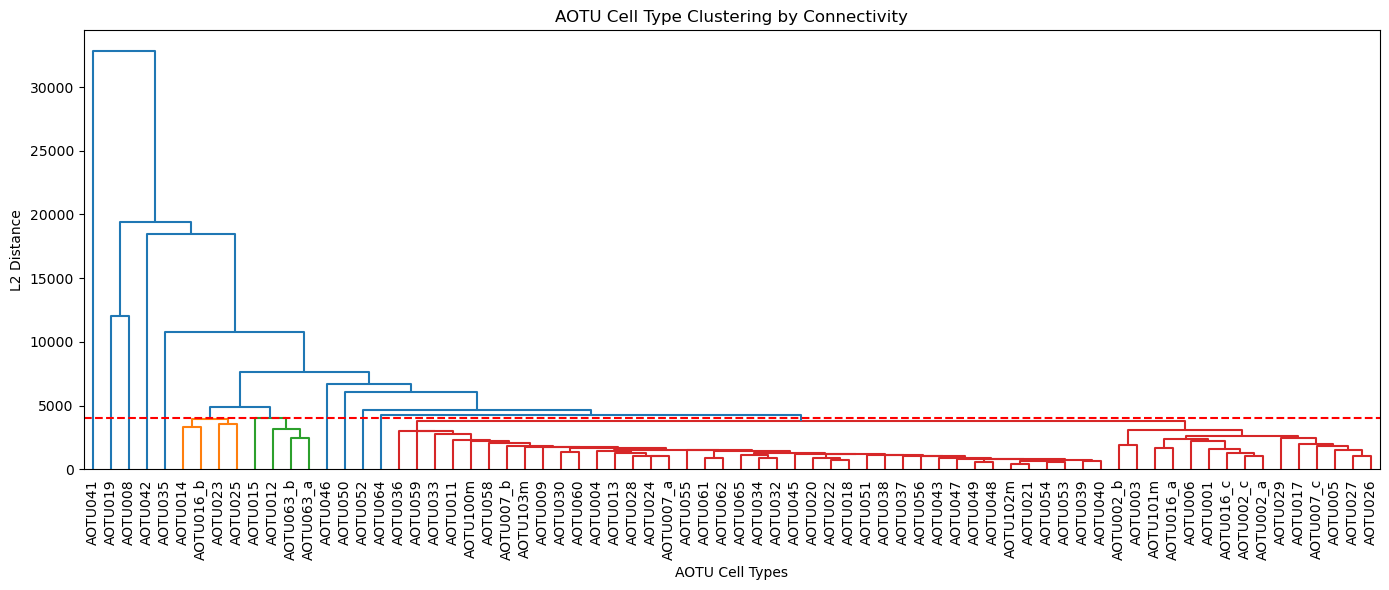

In [ ]:
# Step 3: Visualize with a Dendrogram
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    labels=aotu_order,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=4000
)
plt.axhline(4000, color='red', linestyle='--')
plt.title("AOTU Cell Type Clustering by Connectivity")
plt.ylabel("L2 Distance")
plt.xlabel("AOTU Cell Types")
plt.tight_layout()
plt.show()

# Displays the hierarchy of neuron clusters. The y-axis = distance at which clusters merged.

In [ ]:
# Dynamically Inspect the Distance Scale
print("Distance range:", distance_matrix.min(), "to", distance_matrix.max())
# Using this info to set threshold for distance for the previous step

print("Number of clusters:", len(np.unique(clusters)))

Distance range: 404.50463532572775 to 35146.253299605065
Number of clusters: 12


In [ ]:
# Step 4: Output Cluster Memberships

result_df = pd.DataFrame({
    'AOTU_cell_type': aotu_order,
    'cluster': clusters
})

# Print or save
print(result_df.sort_values('cluster'))
# result_df.to_csv("aotu_connectivity_clusters.csv", index=False)

   AOTU_cell_type  cluster
0         AOTU019        1
26        AOTU008        2
38      AOTU016_b        3
19        AOTU014        3
71        AOTU025        3
..            ...      ...
22        AOTU050        8
21        AOTU046        9
5         AOTU035       10
2         AOTU042       11
1         AOTU041       12

[72 rows x 2 columns]


## Visualize

In [20]:
# we already have:
# - feature_matrix (shape: 72 x 2T)
# - clusters (length: 72)
# - aotu_order (list of AOTU types in feature_matrix order)

# Log-transform to improve contrast (avoid skew from large weights)
log_features = np.log1p(feature_matrix)  # log(1 + x)

# Wrap in a DataFrame for labeling
heatmap_df = pd.DataFrame(
    log_features,
    index=[f"{ctype} (C{cl})" for ctype, cl in zip(aotu_order, clusters)],
    columns=[f"in:{ctype}" for ctype in all_celltypes] +
            [f"out:{ctype}" for ctype in all_celltypes]
)


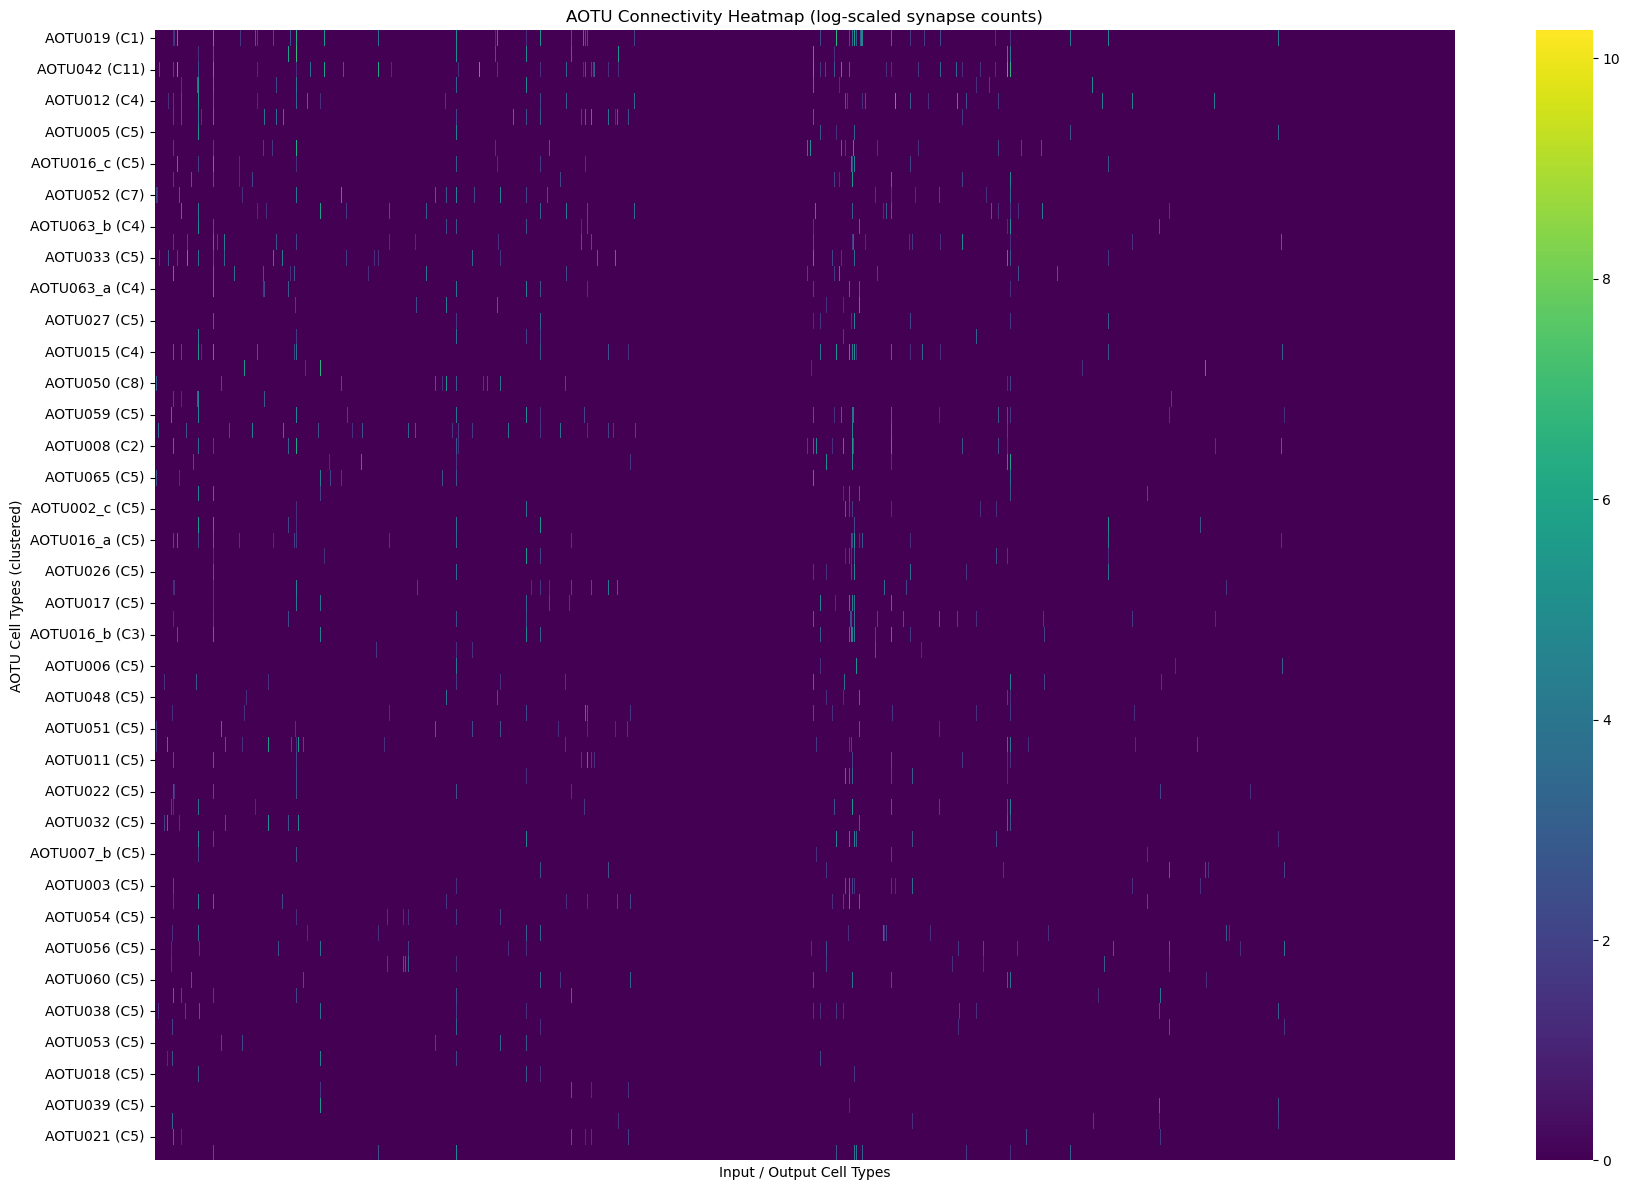

In [21]:
plt.figure(figsize=(18, 12))
sb.heatmap(heatmap_df, cmap='viridis', xticklabels=False)
plt.title("AOTU Connectivity Heatmap (log-scaled synapse counts)")
plt.ylabel("AOTU Cell Types (clustered)")
plt.xlabel("Input / Output Cell Types")
plt.tight_layout()
plt.show()


## Cluster plot

MDS: Dimensionality reduction algorithm that tries to preserve pairwise distances.
Embeds high-dimensional points (here, 2T) into 2D for visualization.
> projecting neurons from a "connectivity space" to a "map space."

pdist() earlier gave a condensed distance vector (upper triangle of the distance matrix).
squareform() turns this into a full symmetric matrix:

$$
\text{distance\_sq}[i,j] = d(i,j)
$$

Shape:If you have 𝑁 AOTU types, distance_sq becomes an N × N matrix.

In [ ]:
from sklearn.manifold import MDS

# Convert distance vector to a squareform matrix
from scipy.spatial.distance import squareform
distance_sq = squareform(distance_matrix)


Apply Multidimensional Scaling (MDS)
Input: dissimilarity='precomputed' tells MDS to use the distance_sq matrix as-is.
Output: aotu_2d_coords: an N × 2 matrix where each row is the (x, y) coordinate of an AOTU type in 2D space.

In [ ]:
# Perform MDS to project into 2D
# Multidimensional scaling (MDS) projection 
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
aotu_2d_coords = mds.fit_transform(distance_sq)

In [23]:
# Assign a color to each cluster
unique_clusters = np.unique(clusters)
palette = sb.color_palette("hsv", len(unique_clusters))
cluster_colors = [palette[np.where(unique_clusters == c)[0][0]] for c in clusters]

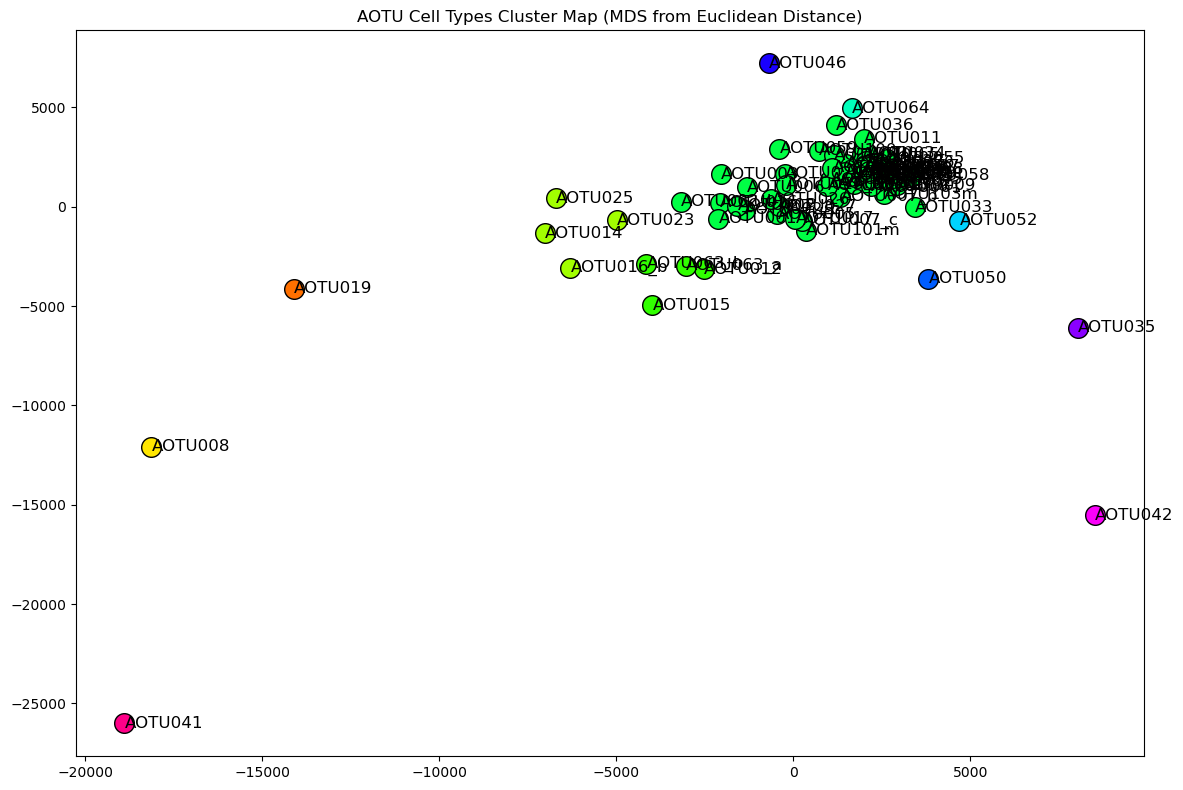

In [24]:
plt.figure(figsize=(12, 8))
for i, (x, y) in enumerate(aotu_2d_coords):
    plt.scatter(x, y, color=cluster_colors[i], s=200, edgecolor='black')
    plt.text(x + 5, y, aotu_order[i], fontsize=12, ha='left', va='center')

plt.title("AOTU Cell Types Cluster Map (MDS from Euclidean Distance)")
plt.axis('on')
plt.tight_layout()
plt.show()

## Cluster plots

In [25]:
from collections import defaultdict

# Group AOTUs by their cluster label
cluster_to_aotus = defaultdict(list)
for name, cl in zip(aotu_order, clusters):
    cluster_to_aotus[cl].append(name)

# Sort clusters (for consistent ordering)
sorted_cluster_labels = sorted(cluster_to_aotus.keys())

In [26]:

# Flatten the ordered list of AOTU types by cluster groupings
ordered_aotus = []
aotu_cluster_labels = []
for cl in sorted_cluster_labels:
    aotus_in_cluster = cluster_to_aotus[cl]
    ordered_aotus.extend(aotus_in_cluster)
    aotu_cluster_labels.extend([cl] * len(aotus_in_cluster))

# Assign equally spaced angles
N = len(ordered_aotus)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)

# Calculate (x, y) coordinates on the circle
radius = 10
x_coords = radius * np.cos(angles)
y_coords = radius * np.sin(angles)

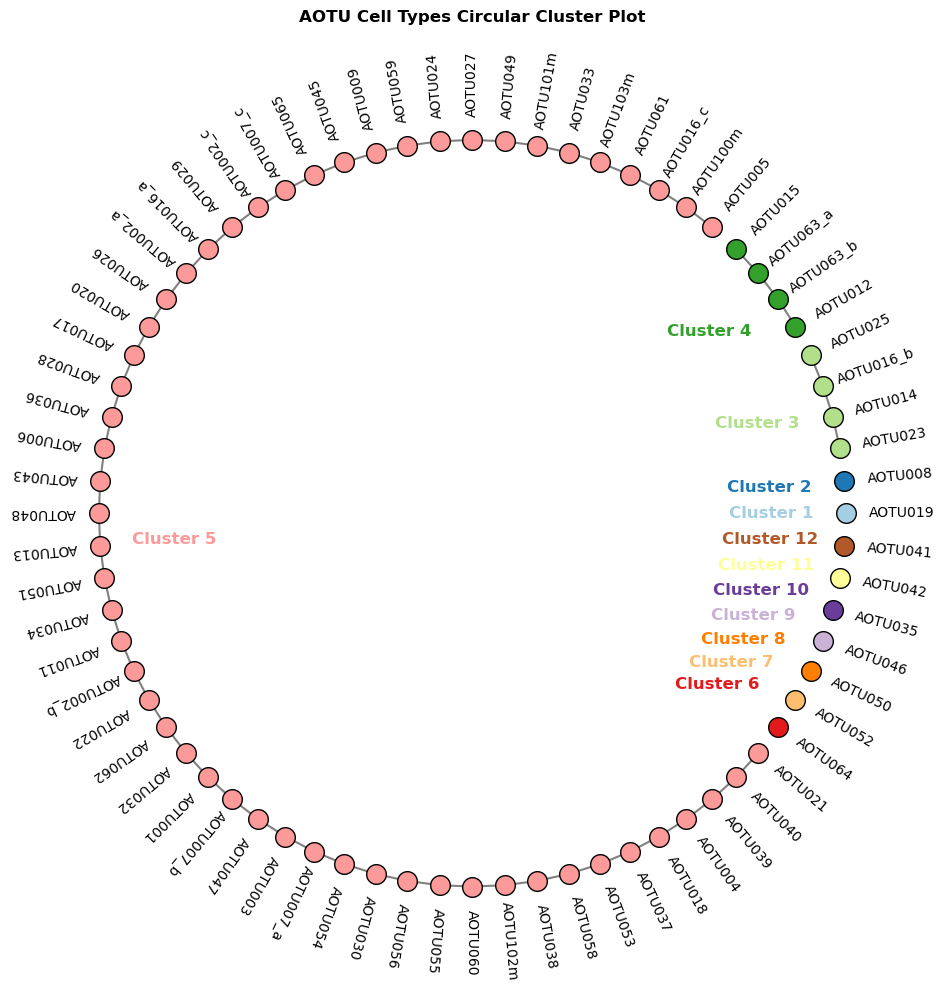

In [56]:
# Assign cluster colors
unique_clusters = sorted(np.unique(clusters))
palette = sb.color_palette("Paired", len(unique_clusters))
cluster_color_map = {cl: palette[i] for i, cl in enumerate(unique_clusters)}
node_colors = [cluster_color_map[cl] for cl in aotu_cluster_labels]

# Plot
plt.figure(figsize=(10, 10))
for i in range(N):
    plt.scatter(x_coords[i], y_coords[i], color=node_colors[i], s=200, edgecolor='black', zorder=3)
    plt.text(
        x_coords[i] * 1.15, y_coords[i] * 1.15, ordered_aotus[i],
        fontsize=10, ha='center', va='center', rotation=np.degrees(angles[i]),
        rotation_mode='anchor'
    )

# Optional: draw edges between adjacent same-cluster nodes
for i in range(N):
    if aotu_cluster_labels[i] == aotu_cluster_labels[(i + 1) % N]:
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % N], y_coords[(i + 1) % N]
        plt.plot([x1, x2], [y1, y2], color='gray', alpha=1, zorder=1)

# Add cluster labels at mean angle for each cluster
for cl in sorted_cluster_labels:
    idxs = [i for i, c in enumerate(aotu_cluster_labels) if c == cl]
    mean_angle = np.mean([angles[i] for i in idxs])
    label_x = radius * 1.6 * np.cos(mean_angle)
    label_y = radius * 1.6 * np.sin(mean_angle)
    plt.text(label_x, label_y, f"Cluster {cl}", fontsize=12, weight='bold', ha='center', va='center', color=cluster_color_map[cl])

# Final formatting
plt.axis('off')       # Hides both axes and bounding box
plt.gca().set_aspect('equal', adjustable='datalim')  # Preserves aspect ratio without showing axes
plt.title("AOTU Cell Types Circular Cluster Plot", pad=60, fontweight='bold')
plt.tight_layout()
plt.show()


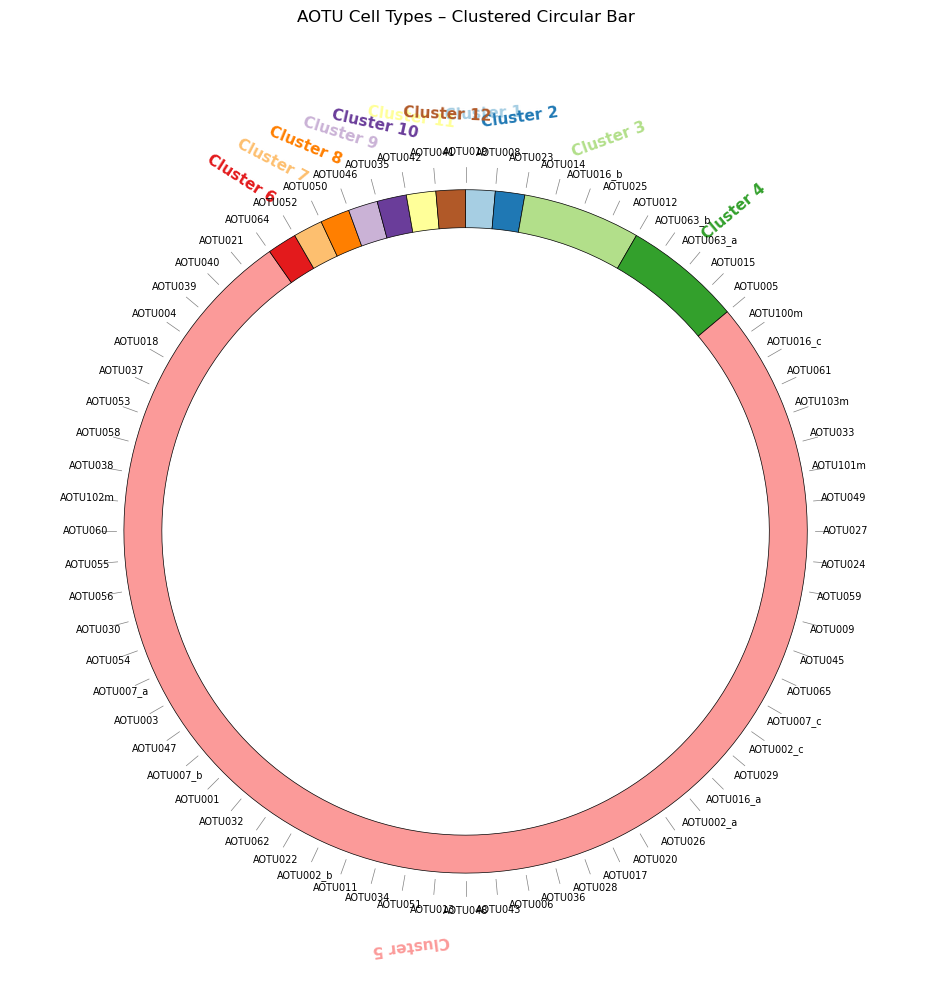

In [44]:
# Set up cluster-to-color mapping
unique_clusters = sorted(np.unique(clusters))
palette = sb.color_palette("Paired", len(unique_clusters))
cluster_color_map = {cl: palette[i] for i, cl in enumerate(unique_clusters)}

# Recompute ordered lists if needed
from collections import defaultdict

cluster_to_aotus = defaultdict(list)
for name, cl in zip(aotu_order, clusters):
    cluster_to_aotus[cl].append(name)

sorted_cluster_labels = sorted(cluster_to_aotus.keys())

ordered_aotus = []
aotu_cluster_labels = []
for cl in sorted_cluster_labels:
    aotus_in_cluster = cluster_to_aotus[cl]
    ordered_aotus.extend(aotus_in_cluster)
    aotu_cluster_labels.extend([cl] * len(aotus_in_cluster))

# Plot parameters
N = len(ordered_aotus)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
bar_thickness = 0.5
inner_radius = 4.0
outer_radius = inner_radius + bar_thickness

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')

# Draw cluster segments as arcs
start_idx = 0
for cl in sorted_cluster_labels:
    count = aotu_cluster_labels.count(cl)
    end_idx = start_idx + count
    theta_start = angles[start_idx]
    theta_end = angles[end_idx - 1] + (angles[1] - angles[0])  # include last arc width
    ax.bar(
        x=(theta_start + theta_end) / 2,
        height=bar_thickness,
        width=theta_end - theta_start,
        bottom=inner_radius,
        color=cluster_color_map[cl],
        edgecolor='black',
        linewidth=0.5
    )

    # Add cluster label
    angle_label = (theta_start + theta_end) / 2
    ax.text(
        angle_label,
        outer_radius + 1,
        f"Cluster {cl}",
        ha='center',
        va='center',
        rotation=np.degrees(angle_label),
        #rotation_mode='anchor',
        fontsize=11,
        weight='bold',
        color=cluster_color_map[cl]
    )

    start_idx = end_idx

# Optional: Add AOTU tick marks or labels
for i, theta in enumerate(angles):
    ax.plot([theta, theta], [outer_radius + 0.1, outer_radius + 0.3], color='gray', linewidth=0.5)
    ax.text(
        theta,
        outer_radius + 0.5,
        ordered_aotus[i],
        fontsize=7,
        ha='center',
        va='center',
        #rotation=np.degrees(theta),
        #rotation_mode='anchor'
    )

# Clean plot
ax.set_ylim(0, outer_radius + 1.5)
ax.axis('off')
plt.title("AOTU Cell Types – Clustered Circular Bar", y=1.05)
plt.tight_layout()
plt.show()

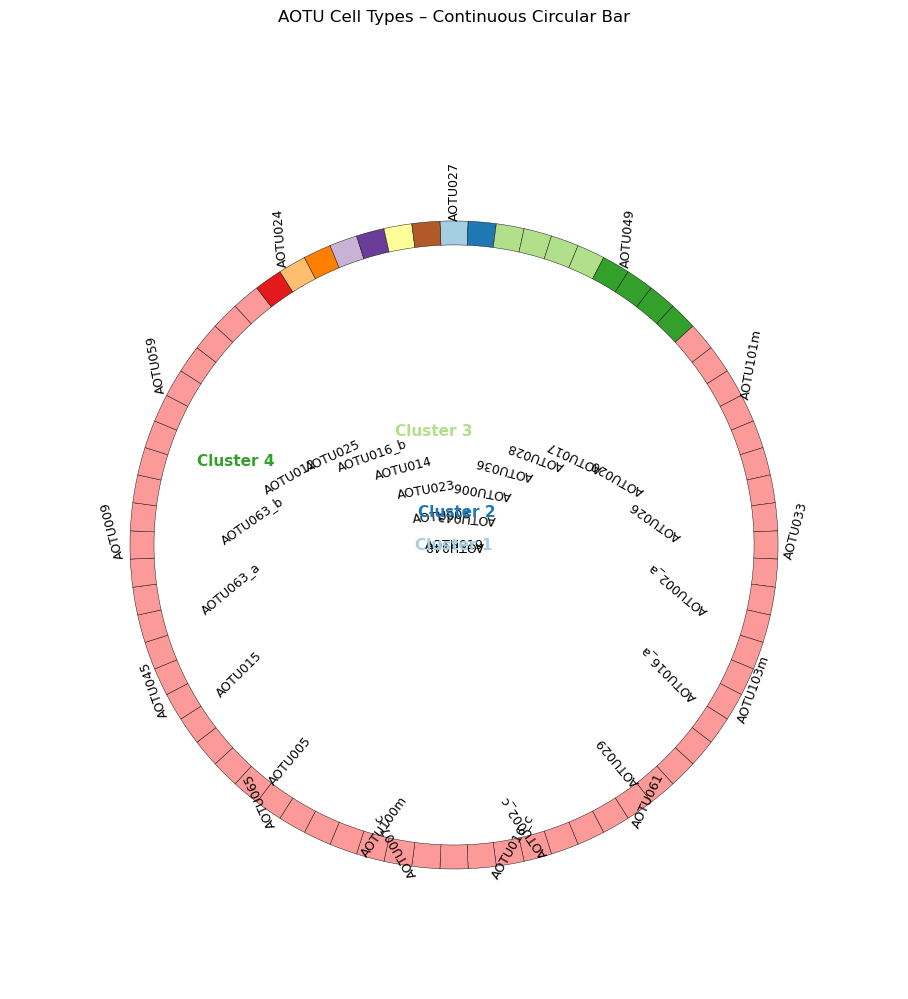

In [45]:
# --- Cluster-to-color mapping ---
unique_clusters = sorted(np.unique(clusters))
palette = sb.color_palette("Paired", len(unique_clusters))
cluster_color_map = {cl: palette[i] for i, cl in enumerate(unique_clusters)}

# --- Reorder AOTUs by cluster ---
cluster_to_aotus = defaultdict(list)
for name, cl in zip(aotu_order, clusters):
    cluster_to_aotus[cl].append(name)

sorted_cluster_labels = sorted(cluster_to_aotus.keys())

ordered_aotus = []
aotu_cluster_labels = []
for cl in sorted_cluster_labels:
    aotus = cluster_to_aotus[cl]
    ordered_aotus.extend(aotus)
    aotu_cluster_labels.extend([cl] * len(aotus))

# --- Plot setup ---
N = len(ordered_aotus)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
radius = 5.0
bar_thickness = 0.4
inner_radius = radius
outer_radius = inner_radius + bar_thickness

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')

# --- Draw bar segments for each AOTU ---
bar_width = (2 * np.pi) / N

for i, theta in enumerate(angles):
    cl = aotu_cluster_labels[i]
    ax.bar(
        theta,
        height=bar_thickness,
        width=bar_width,
        bottom=inner_radius,
        color=cluster_color_map[cl],
        edgecolor='black',
        linewidth=0.3
    )

# --- AOTU labels ---
label_radius = outer_radius + 0.5
for i, theta in enumerate(angles):
    angle_deg = np.degrees(theta)
    x = label_radius * np.cos(theta)
    y = label_radius * np.sin(theta)

    ax.text(
        x, y,
        ordered_aotus[i],
        fontsize=9,
        ha='center',
        va='center',
        rotation=angle_deg,
        rotation_mode='anchor'
    )

# --- Optional: add cluster labels at mean angle ---
for cl in sorted_cluster_labels:
    idxs = [i for i, c in enumerate(aotu_cluster_labels) if c == cl]
    mean_angle = np.mean([angles[i] for i in idxs])
    label_radius_cl = outer_radius + 1.0
    x = label_radius_cl * np.cos(mean_angle)
    y = label_radius_cl * np.sin(mean_angle)

    ax.text(
        x, y,
        f"Cluster {cl}",
        fontsize=11,
        weight='bold',
        ha='center',
        va='center',
        color=cluster_color_map[cl]
    )

# --- Final formatting ---
ax.set_ylim(0, outer_radius + 2)
ax.axis('off')
plt.title("AOTU Cell Types – Continuous Circular Bar", y=1.08)
plt.tight_layout()
plt.show()
